In [1]:
##import modules
import csv 
import sys
import pickle

import matplotlib.pyplot as plt

In [2]:
print("module imported")

module imported


In [3]:
import pickle
import numpy as np

import os
import json

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from sklearn.preprocessing import LabelBinarizer

from sklearn.utils import shuffle

Using TensorFlow backend.


In [4]:
#ch, row, col = 3, 160, 320
channels, rows, columns = 3, 66, 200  # camera format

In [5]:
#Fetch data from pickle file
with open('data/driving_data.p', mode='rb') as f:
    driving_data = pickle.load(f)

center_images = driving_data['center_images']
left_images = driving_data['left_images']
right_images = driving_data['right_images']
labels = driving_data['labels']

#shuffle a dataset
#images, labels = shuffle(center_images, labels)

# split train & valid data
X_train, X_validation, y_train, y_validation = train_test_split(center_images, labels, test_size=0.1, random_state=42)

print(X_train[0].shape)
print(len(X_train))
print(len(X_validation))


(1, 66, 200, 3)
6615
735


In [6]:
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

#center_images = normalize_grayscale(center_images)
#left_images = normalize_grayscale(left_images)
#right_images = normalize_grayscale(right_images)

#center_images = (center_images - 127)/128 
#left_images = (left_images - 127)/128
#right_images = (right_images - 127)/128


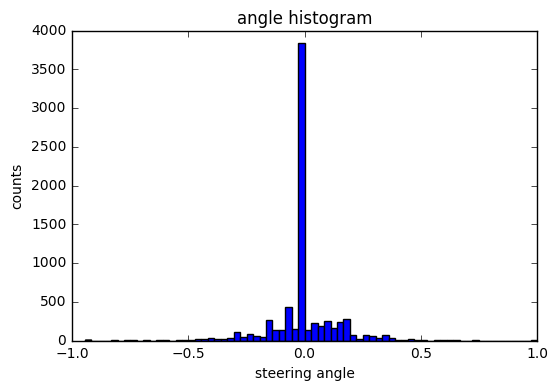

In [7]:
# histogram of labels count

plt.hist(labels, bins=70)
plt.title('angle histogram')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()


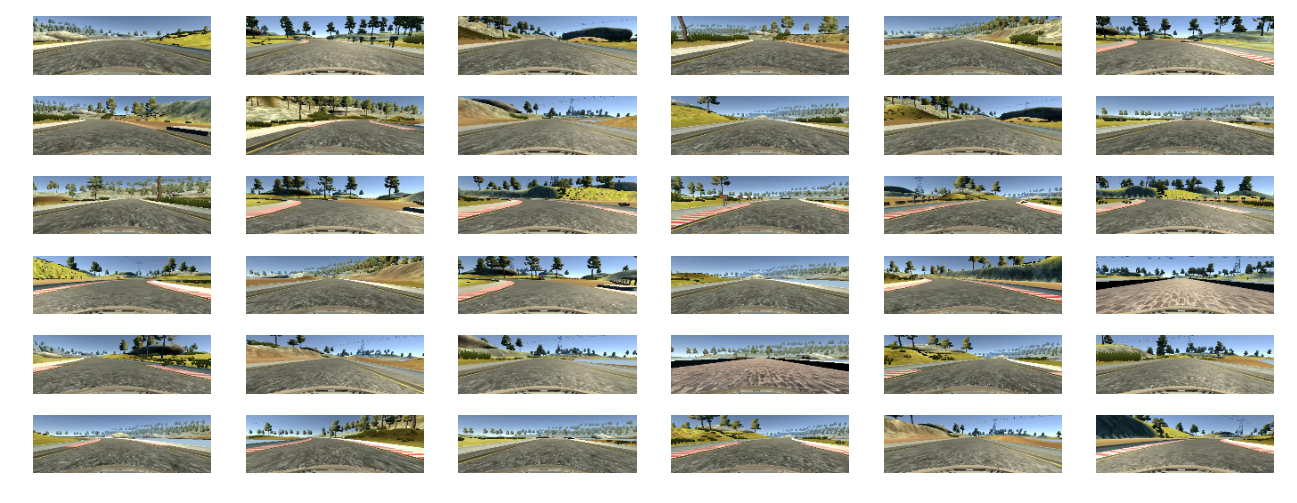

In [8]:
#Randomly print few images
plt.figure(figsize=(16,6))
for i in range(36):
    random_index = np.random.randint(0,len(X_train))
    plt.subplot(6,6,i+1)
    plt.imshow(X_train[random_index].squeeze(), cmap="gray");
    plt.axis('off')
plt.show()

In [9]:
def commaai_model(time_len=1):

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, input_shape=(3,160,320), subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    return model

def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model


In [10]:
#TODO: add offsets? Why, I don't know
def get_image(center_images, left_images, right_images, labels, index, image_offset=0.25):
    
    camera = np.random.choice(['center', 'left', 'right'])

    if camera == 'center':
        image, steering = center_images[index], float(labels[index])
    elif camera == 'left':
        image, steering = left_images[index], float(labels[index])+image_offset
    elif camera == 'right':
        image, steering = right_images[index], float(labels[index])-image_offset

    return image, steering

#Generator, and training
def my_generator(center_images, left_images, right_images, labels, batch_size):
    batch_train = np.zeros((batch_size, rows, columns, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        for index in range(batch_size):
            batch_train[i], batch_angle[i] = get_image(center_images, left_images, right_images, labels, index)
        yield batch_train, batch_angle

In [11]:
batch_size = 64
EPOCHS = 10

model = nvidia_model()

#print model summary
#model.summary()

# Compile model using Adam optimizer
# and loss computed by mean squared error
model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['accuracy'], 
              validation_data=(X_validation, y_validation), 
              verbose=1)

my_generator = my_generator(center_images, left_images, right_images, labels, batch_size)

# Model training
# TODO: Add validation data
history = model.fit_generator(
    my_generator,
    samples_per_epoch=64*103, # of training samples
    nb_epoch=EPOCHS,
    verbose=1
)

print("model training complete")

/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
6592/6592 [==============================] - 47s - loss: 0.0977 - acc: 0.9143    
Epoch 2/10
6592/6592 [==============================] - 48s - loss: 9.0464e-04 - acc: 0.9848    
Epoch 3/10
6592/6592 [==============================] - 53s - loss: 0.0011 - acc: 0.9844    
Epoch 4/10
6592/6592 [==============================] - 48s - loss: 8.4126e-04 - acc: 0.9844    
Epoch 5/10
6592/6592 [==============================] - 44s - loss: 9.9916e-04 - acc: 0.9847
Epoch 6/10
6592/6592 [==============================] - 44s - loss: 9.4418e-04 - acc: 0.9844    
Epoch 7/10
6592/6592 [==============================] - 42s - loss: 7.4586e-04 - acc: 0.9847    
Epoch 8/10
6592/6592 [==============================] - 42s - loss: 6.4175e-04 - acc: 0.9848    
Epoch 9/10
6592/6592 [==============================] - 43s - loss: 6.0237e-04 - acc: 0.9845    
Epoch 10/10
6592/6592 [==============================] - 42s - loss: 5.7705e-04 - acc: 0.9845    
model training complete


In [13]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved")

model saved
